In [2]:
from math import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from jupyterthemes import jtplot

In [20]:
jtplot.style(grid=True)

In [4]:
def vRb(e):
    vRb = np.zeros([3,3])
    vRb[0,0] = e[0]**2+e[1]**2 - e[2]**2 - e[3]**2
    vRb[0,1] = 2*(e[1]*e[2]-e[0]*e[3])
    vRb[0,2] = 2*(e[1]*e[3]+e[0]*e[2])
    
    vRb[1,0] = 2*(e[1]*e[2]+e[0]*e[3])
    vRb[1,1] = e[2]**2+e[0]**2-e[1]**2-e[3]**2
    vRb[1,2] = 2*(e[2]*e[3]-e[0]*e[1])

    vRb[2,0] = 2*(e[1]*e[3]-e[0]*e[2])
    vRb[2,1] = 2*(e[2]*e[3]+e[0]*e[1])
    vRb[2,2] = e[3]**2+e[0]**2-e[1]**2-e[2]**2
    return vRb
def bRv(e):
    rot = vRb(e)
    return rot.T
def quaternion_update_matrix(angular_velocity):
    M = np.zeros([4,4])
    
    M[0,0] = 0
    M[0,1] = -angular_velocity[0]
    M[0,2] = -angular_velocity[1]
    M[0,3] = -angular_velocity[2]
    
    M[1,0] = angular_velocity[0]
    M[1,1] = 0
    M[1,2] = -angular_velocity[2]
    M[1,3] = angular_velocity[1]

    M[2,0] = angular_velocity[1]
    M[2,1] = angular_velocity[2]
    M[2,2] = 0
    M[2,3] = -angular_velocity[0]
    
    M[3,0] = angular_velocity[2]
    M[3,1] = -angular_velocity[1]
    M[3,2] = angular_velocity[0]
    M[3,3] = 0
    
    return -0.5 * M
    
    return M
def Inertia(Ix,Iy,Iz):
    return np.diag(np.array([Ix,Iy,Iz]))

# Checks if a matrix is a valid rotation matrix.

def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6
def rotationMatrixToQuaternion(R):
    assert isRotationMatrix(R)
    e0 = np.sqrt(1+R[0,0] + R[1,1] + R[2,2])
    e1 = (R[2,1] - R[1,2])/(4*e0)
    e2 = (R[0,2] - R[2,0])/(4*e0)
    e3 = (R[1,0] - R[0,1])/(4*e0)
    q = np.array([e0,e1,e2,e3])
    q /= np.linalg.norm(q)
    return q.T
def EulerFromQuaternion(quaternion):
    e0 = quaternion[0]
    e1 = quaternion[1]
    e2 = quaternion[2]
    e3 = quaternion[3]
    
    roll = np.math.atan2(2*(e0*e1+e2*e3),e0**2+e3**2-e1**2-e2**2)
    pitch = np.math.asin(2*(e0*e2-e1*e3))
    yaw = np.math.atan2(2*(e0*e3+e1*e2),e0**2+e1**2-e2**2-e3**2)
    
    return np.array([roll,pitch,yaw]).T
# returns the quaternion Kronecker product p*q
def quatProd(p,q):
    Q = np.array([[p[0],-p[1],-p[2],-p[3]],
                  [p[1],p[0],-p[3],p[2]],
                  [p[2],p[3],p[0],-p[1]],
                  [p[3],-p[2],p[1],p[0]]])
    return Q @ q
def conjugateQuaternion(q):
    return np.array([q[0],-q[1],-q[2],-q[3]]).T

In [5]:
# returns X_dot = f(X,U) system of differential equations
def f(X,U,eta,mass,Ix,Iy,Iz):
    
    X_dot = np.zeros(X.shape[0])
    X_dot[:3] = np.dot(vRb(X[3:7]),X[7:10])
    X_dot[3:7] = np.dot(quaternion_update_matrix(X[10:]),X[3:7])
    X_dot[7:10] = (1/mass) * U[:3] + np.cross(X[7:10],X[10:])
    X_dot[10:] = np.dot(np.linalg.pinv(Inertia(Ix,Iy,Iz)),np.cross(np.dot(Inertia(Ix,Iy,Iz),X[10:]),X[10:]) + U[3:])
    
    return X_dot

# maps from error to input (fx,fy,fz), at current time step

def getPositionFromState(X):
    return X[:3] # inertial position
    print(np.random.normal(size=[3]))
def getVelocityFromState(X):
    return X[7:10]
def getQuaternionFromState(X):
    return X[3:7]
def getAngularVeloctiyFromState(X):
    return X[10:]
def integrateFunction(f,dt):
    return (2*np.sum(f[:,1:-1],axis=1) + f[:,0] + f[:,-1])*(dt/2)

def controlLaw(error_p,error_d,error_i,Kp,Kd,Ki):
    return error_p*Kp + error_d*Kd + error_i * Ki
        
def initStates():
    X = np.zeros([13,n+1])

    # setting the initial position
    X[0,0] = 0
    X[1,0] = -3
    X[2,0] = -3
    
    
    ## setting the initial quaternion
    X[3,0] = np.sqrt(1/2) 
    X[5,0] = np.sqrt(1/2)
    
    
    
    return X
def initInputs():
    U = np.zeros([6,n+1])
    
    return U

In [6]:
# parameters
mass = 1
eta = 1000
Ix = 1
Iy = 1
Iz = 1

# time parameters

dt = 0.005
t_finish = 20.0
n = int(t_finish/dt)
t_values = np.linspace(0,t_finish,n+1)


In [7]:
# generated desired trajectory : a circle maid air
R = 3
ω = 2
Vz = 0.5
desired_position = np.zeros([3,n])
desired_velocity = np.zeros([3,n])
#desired_attitude = np.zeros([3,3])

desired_quaternion = np.zeros([4,n])

for i in range(n):
    desired_position[0,i] = R*np.cos(ω*i*dt)
    desired_position[1,i] = R*np.sin(ω*i*dt)
    desired_position[2,i] = Vz*i*dt # constant altitude (NED convention z is positive downwards)
    
    desired_velocity[0,i] = -ω*R*np.sin(ω*i*dt)
    desired_velocity[1,i] = ω*R*np.cos(ω*i*dt)
    desired_velocity[2,i] = Vz
    
    desired_quaternion[0,i] = np.sqrt(1/2)*(np.cos(0.5*ω*dt*i) + np.sin(0.5*ω*dt*i))
    desired_quaternion[3,i] = np.sqrt(1/2)*(np.sin(0.5*ω*dt*i) - np.cos(0.5*ω*dt*i))

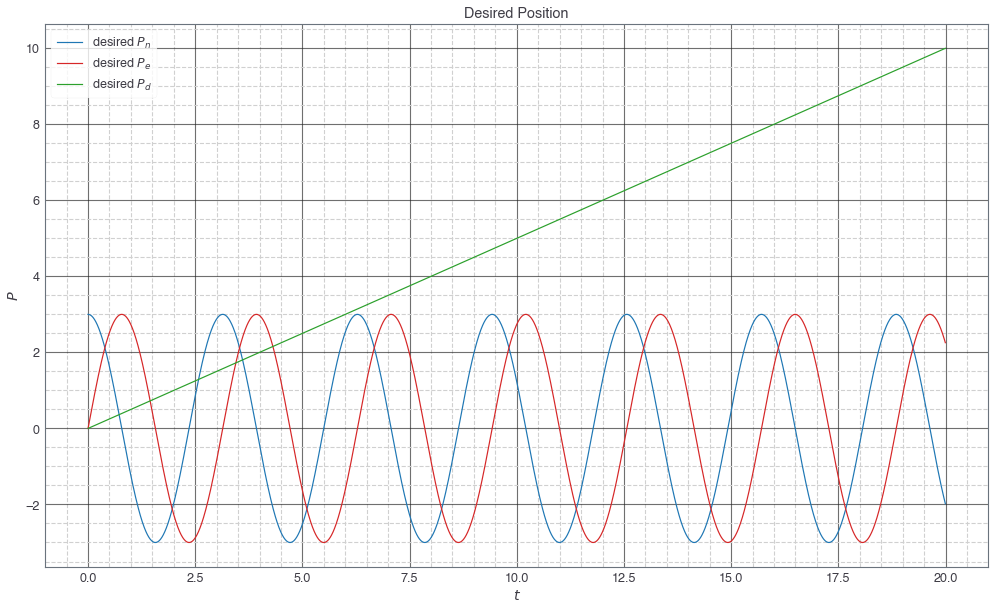

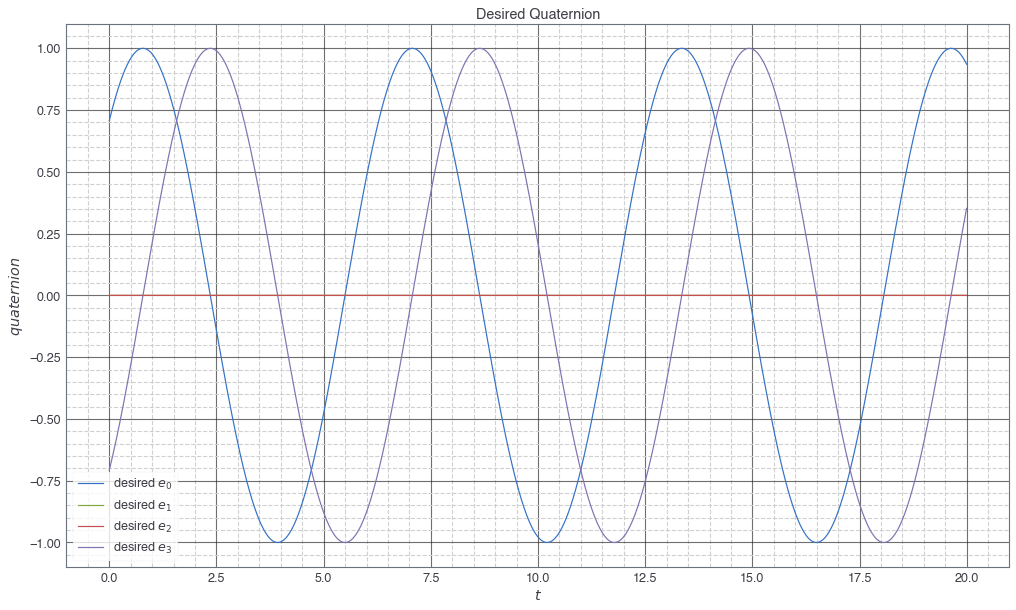

In [21]:
plt.figure(0,figsize = (16.9,10))

# Plot paths
plt.plot(t_values[:-1],desired_position[0,:],label=r'desired $P_n$',color="tab:blue")
plt.plot(t_values[:-1],desired_position[1,:],label=r'desired $P_e$',color="tab:red")
plt.plot(t_values[:-1],desired_position[2,:],label=r'desired $P_d$',color="tab:green")

# Add legend and axes labels
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.ylabel(r'$P$')
plt.title("Desired Position")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()
plt.show()

plt.figure(1,figsize = (16.9,10))
plt.grid()
# Plot quaternions
plt.plot(t_values[:-1], desired_quaternion[0,:], label=r'desired $e_0$')
plt.plot(t_values[:-1], desired_quaternion[1,:], label=r'desired $e_1$')
plt.plot(t_values[:-1], desired_quaternion[2,:], label=r'desired $e_2$')
plt.plot(t_values[:-1], desired_quaternion[3,:], label=r'desired $e_3$')
# Add legend and axes labels
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.ylabel(r'$quaternion$')
plt.title("Desired Quaternion")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()
plt.show()

In [9]:
# numerical solution using RK4 
X = initStates()
U = initInputs()


# PID gains
Kp = np.array([45,45,45]) # Kpx,Kpy,Kpz
Kd = np.array([25,25,20]) # Kdx,Kdy,Kdz
Ki = np.array([1,1,1]) # Kix,Kiy,Kiz

K_quat = 15
K_w = 3
I = Inertia(Ix,Iy,Iz)
position_noise = 0
attitude_noise = 0

#K_pw = 5
#K_iw = 2

error_ps = np.zeros([3,n]) # for integration purposes
w_errors = np.zeros([3,n]) # for intergration purposes

F_des = np.zeros([3,n])
for i in range(n):
    # position control
    error_p = desired_position[:,i] - getPositionFromState(X[:,i]) + position_noise*np.random.normal() 
    error_ps[:,i] = error_p
    error_d = desired_velocity[:,i] - vRb(getQuaternionFromState(X[:,i])) @ getVelocityFromState(X[:,i])
    if i == 0:
        error_i = error_p
    else:
        error_i = integrateFunction(error_ps[:,:i],dt)
    
    ## we get force input in the inertial frame
    for j in range(3):
        U[j,i] = mass * controlLaw(error_p[j],error_d[j],error_i[j],Kp[j],Kd[j],Ki[j])
    
    
    
    # map it back to the body frame
    U[:3,i] = bRv(getQuaternionFromState(X[:,i])) @ U[:3,i]
    
    
    q_err = quatProd(desired_quaternion[:,i],
                     conjugateQuaternion(X[3:7,i])) + attitude_noise*np.random.normal()
    axis_err = q_err[1:]
    U[3:,i] = -K_quat*axis_err - K_w*X[10:,i]
    
    # ad hoc disturbance
    if i > int(n/2) and i < 30 + int(n/2):
        U[:,i] += 0
    
    ## update section. DO NOT MESS WITH IT.
    K1 = dt*f(X[:,i],U[:,i],eta,mass,Ix,Iy,Iz)
    K2 = dt*f(X[:,i]+0.5*K1,U[:,i],eta,mass,Ix,Iy,Iz)
    K3 = dt*f(X[:,i]+0.5*K2,U[:,i],eta,mass,Ix,Iy,Iz)
    K4 = dt*f(X[:,i]+K3,U[:,i],eta,mass,Ix,Iy,Iz)

    X[:,i+1] = X[:,i] + (K1+2*K2+2*K3+K4)/6

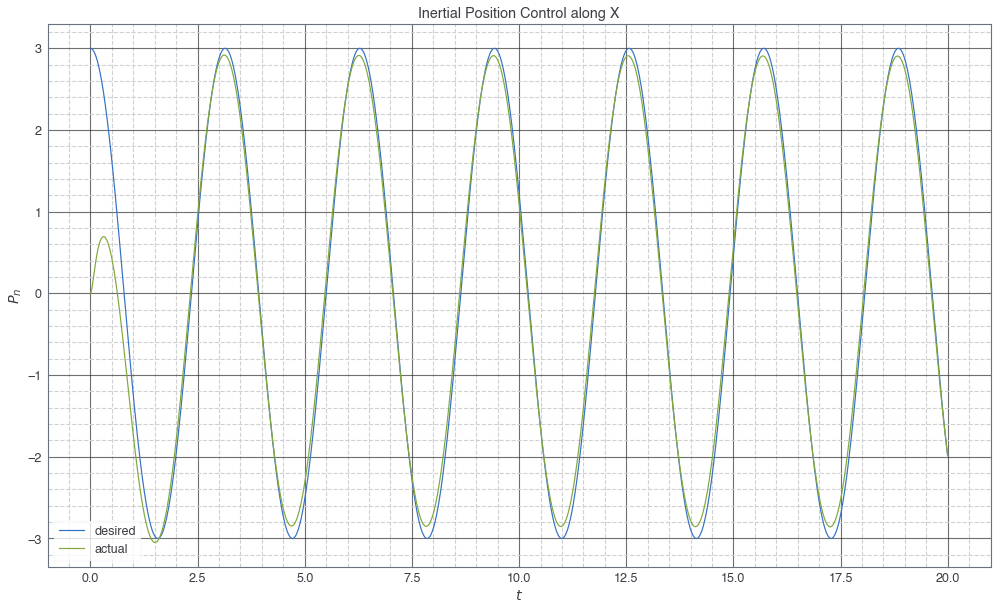

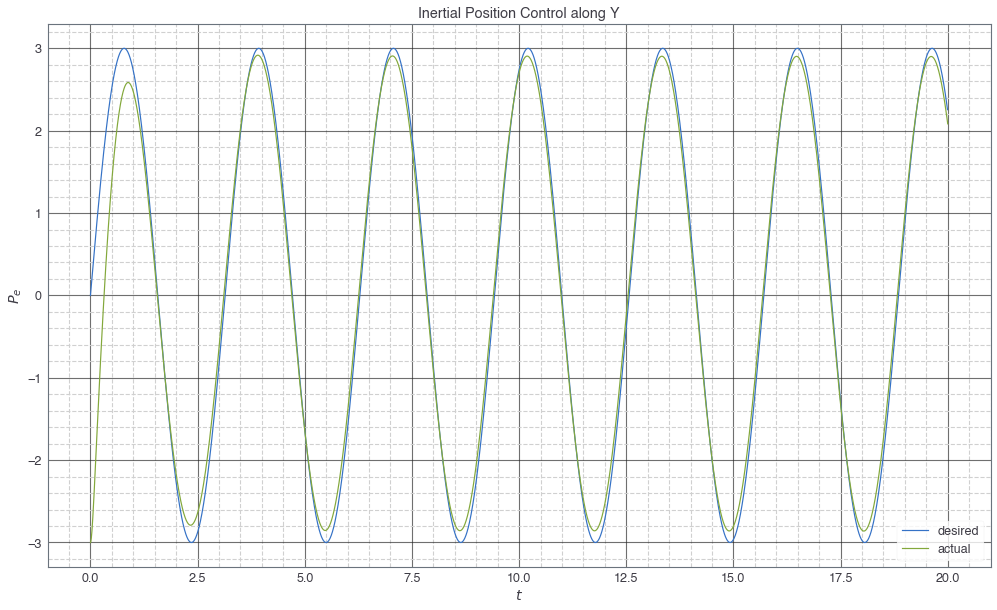

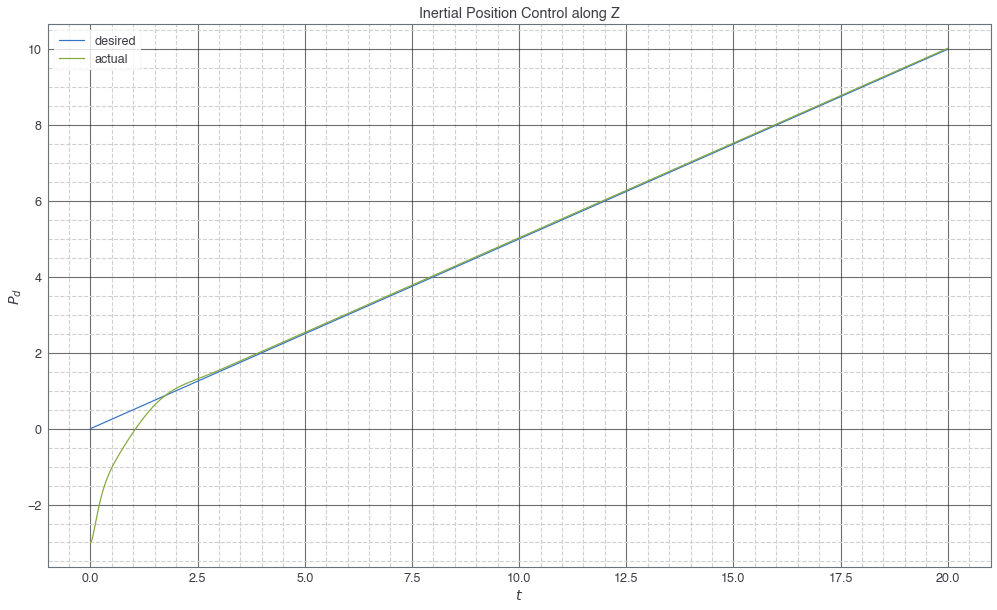

In [10]:
plt.figure(0,figsize = (16.9,10))
plt.grid()
# Plot paths
plt.plot(t_values[:-1],desired_position[0,:],label=r'desired')
plt.plot(t_values, X[0,:], label='actual')
# Add legend and axes labels
plt.legend(loc = 0)
plt.xlabel(r'$t$')
#plt.xticks(np.arange(min(t_values), max(t_values)+1, 2.5))
plt.ylabel(r'$P_n$')
plt.title("Inertial Position Control along X")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()
plt.show()

plt.figure(1,figsize = (16.9,10))
plt.grid()
# Plot paths
plt.plot(t_values[:-1],desired_position[1,:],label=r'desired')
plt.plot(t_values, X[1,:], label='actual')
# Add legend and axes labels
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.ylabel(r'$P_e$')
plt.title("Inertial Position Control along Y")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()
plt.show()


plt.figure(2,figsize = (16.9,10))
plt.grid()
# plot paths
plt.plot(t_values[:-1],desired_position[2,:],label = 'desired')
plt.plot(t_values, X[2,:], label = 'actual')
# Add legend and axes labels
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.ylabel(r'$P_d$')
plt.title("Inertial Position Control along Z")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()
plt.show()

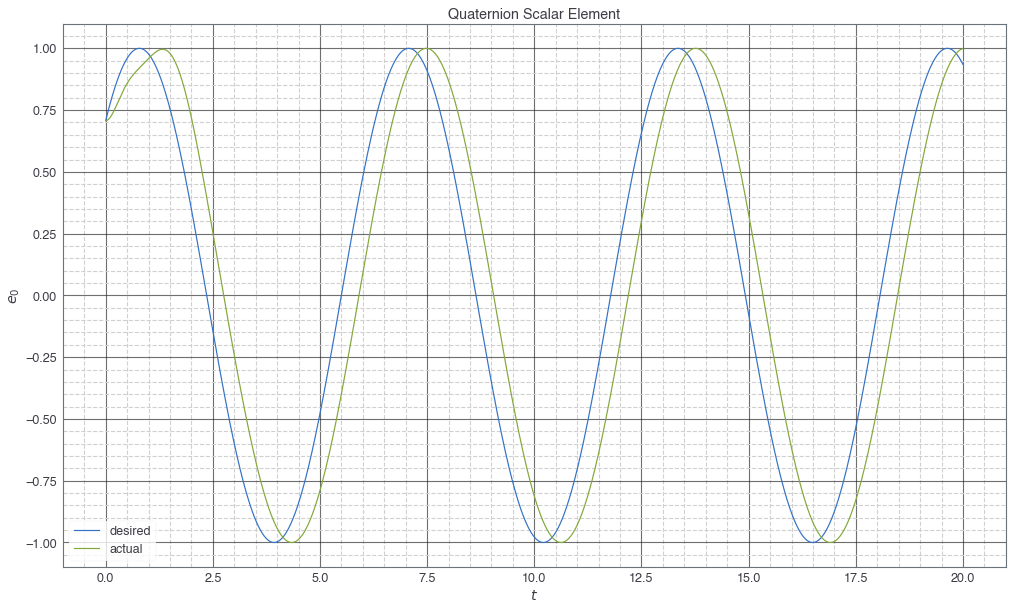

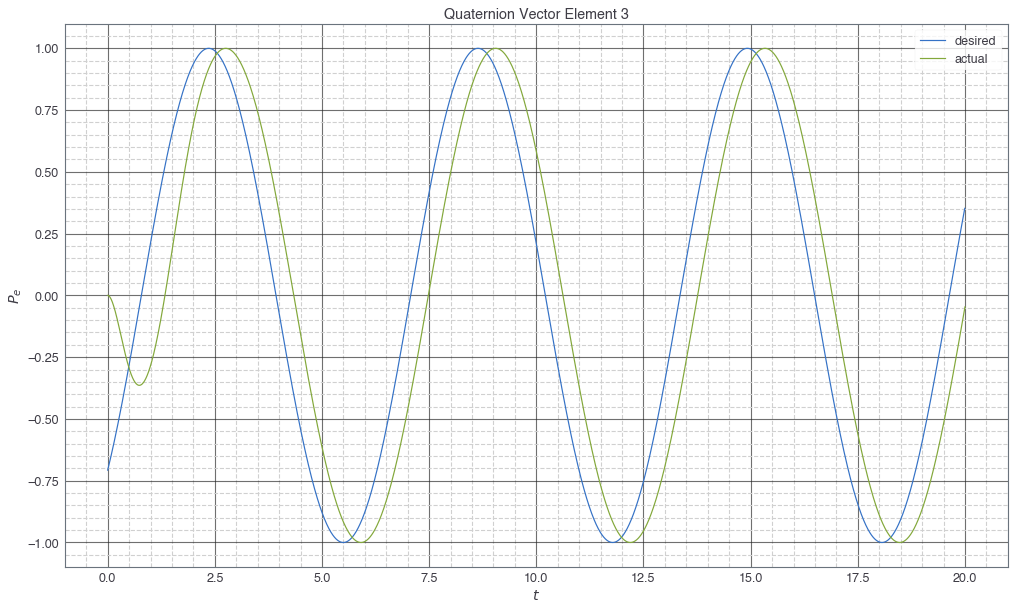

In [11]:
plt.figure(0,figsize = (16.9,10))
plt.grid()

# Plot paths
plt.plot(t_values[:-1],desired_quaternion[0,:],label=r'desired')
plt.plot(t_values, X[3,:], label='actual')


# Add legend and axes labels
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.ylabel(r'$e_0$')
plt.title("Quaternion Scalar Element")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()
plt.show()

plt.figure(1,figsize = (16.9,10))
plt.grid()

# Plot paths
plt.plot(t_values[:-1],desired_quaternion[3,:],label=r'desired')
plt.plot(t_values, X[6,:], label='actual')


# Add legend and axes labels
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.ylabel(r'$P_e$')
plt.title("Quaternion Vector Element 3")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()
plt.show()

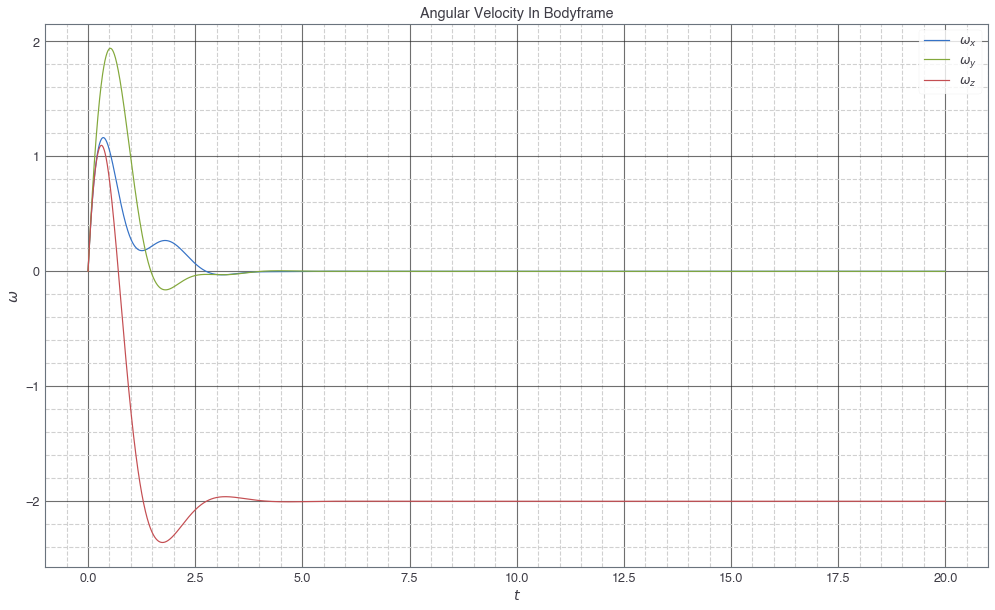

In [12]:
plt.figure(0,figsize = (16.9,10))
plt.grid()

# Plot paths
plt.plot(t_values, X[10,:], label=r'$\omega_x$')
plt.plot(t_values, X[11,:], label=r'$\omega_y$')
plt.plot(t_values, X[12,:], label=r'$\omega_z$')

# Add legend and axes labels
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.ylabel(r'$\omega$')
plt.title("Angular Velocity In Bodyframe")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()
plt.show()

<ipython-input-13-9ea5f8c13f37>:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


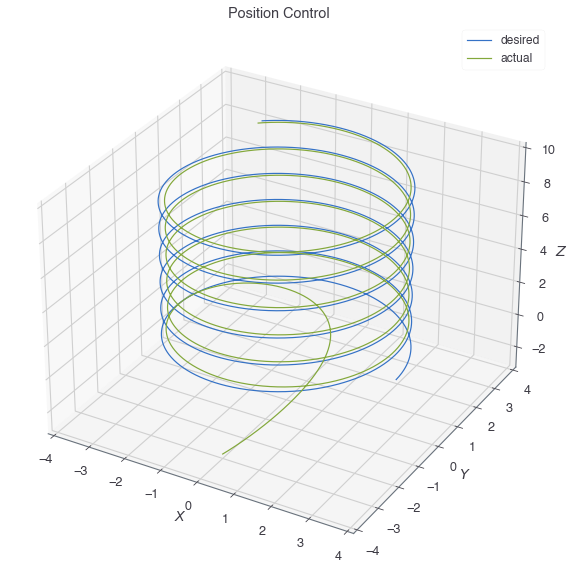

In [13]:
mpl.rcParams['legend.fontsize'] = 12

fig = plt.figure(figsize=(16.9,10))
ax = fig.gca(projection='3d')

ax.plot(desired_position[0,:],desired_position[1,:],desired_position[2,:], label='desired')
ax.plot(X[0,:], X[1,:], X[2,:], label='actual')

ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
#ax.set_zlim([-20,20])
ax.legend(loc = 0)

ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$Y$')
ax.set_zlabel(r'$Z$')

plt.title("Position Control")
plt.show()

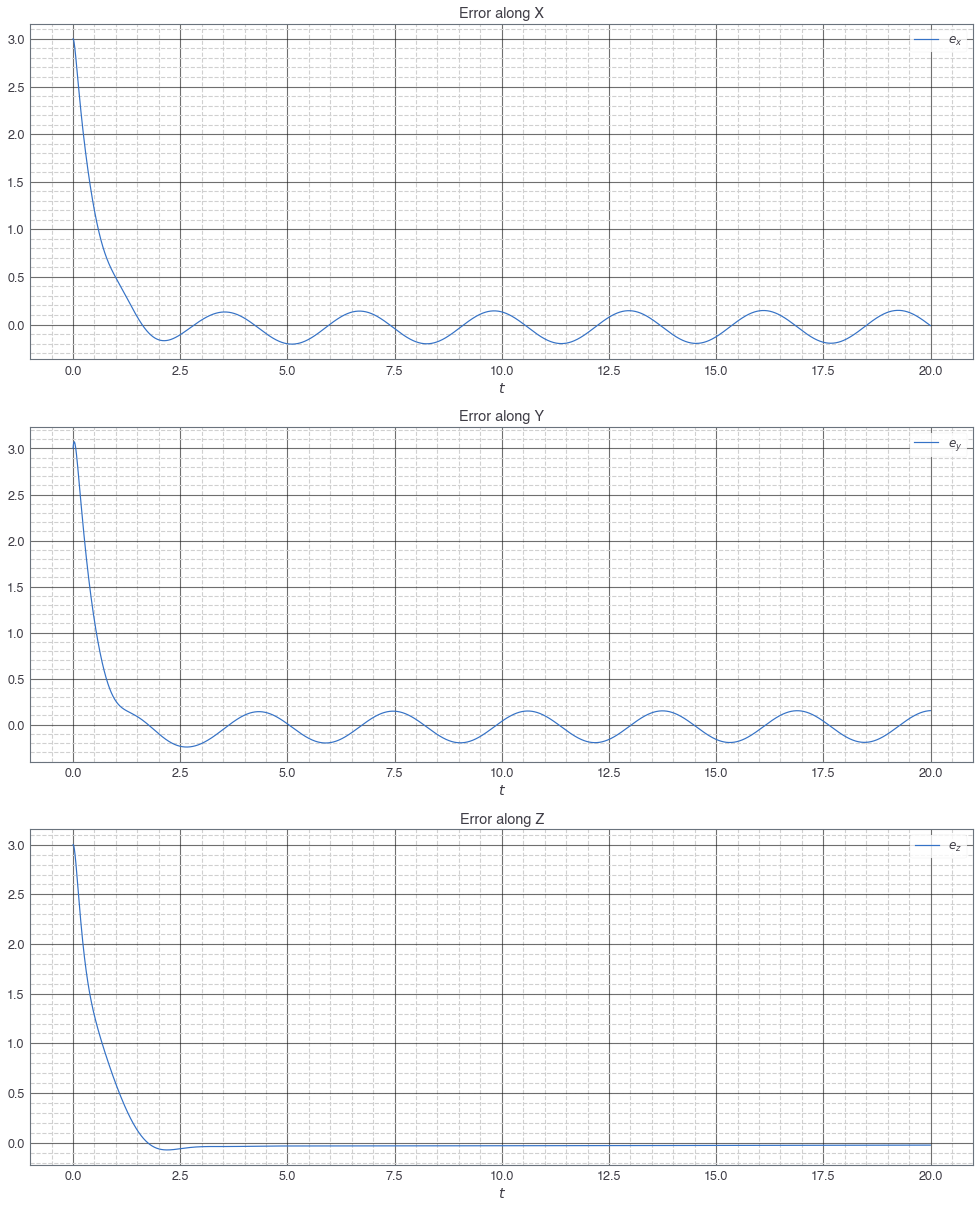

In [14]:
plt.figure(0,figsize = (16.9,21))

plt.subplot(3,1,1)
plt.grid()
plt.plot(t_values[:-1],error_ps[0,:],label=r'$e_x$')
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.title("Error along X")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()

plt.subplot(3,1,2)
plt.grid()
plt.plot(t_values[:-1],error_ps[1,:],label=r'$e_y$')
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.title("Error along Y")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()

plt.subplot(3,1,3)
plt.grid()
plt.plot(t_values[:-1],error_ps[2,:],label=r'$e_z$')
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.title("Error along Z")

plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()
plt.show()

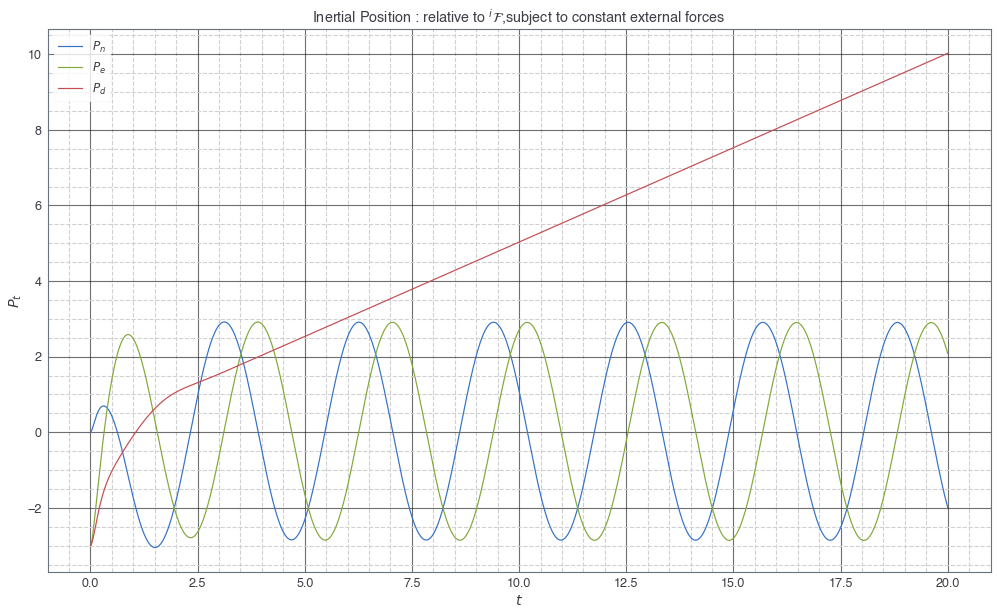

In [15]:
plt.figure(0,figsize = (16.9,10))
plt.grid()

# Plot paths
plt.plot(t_values, X[0,:], label=r'$P_n$')
plt.plot(t_values, X[1,:], label=r'$P_e$')
plt.plot(t_values, X[2,:], label=r'$P_d$')

# Add legend and axes labels
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.ylabel(r'$P_{t}$')
plt.title("Inertial Position : relative to $^i\mathcal{F}$,"+ 
          "subject to constant external forces")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()
plt.show()

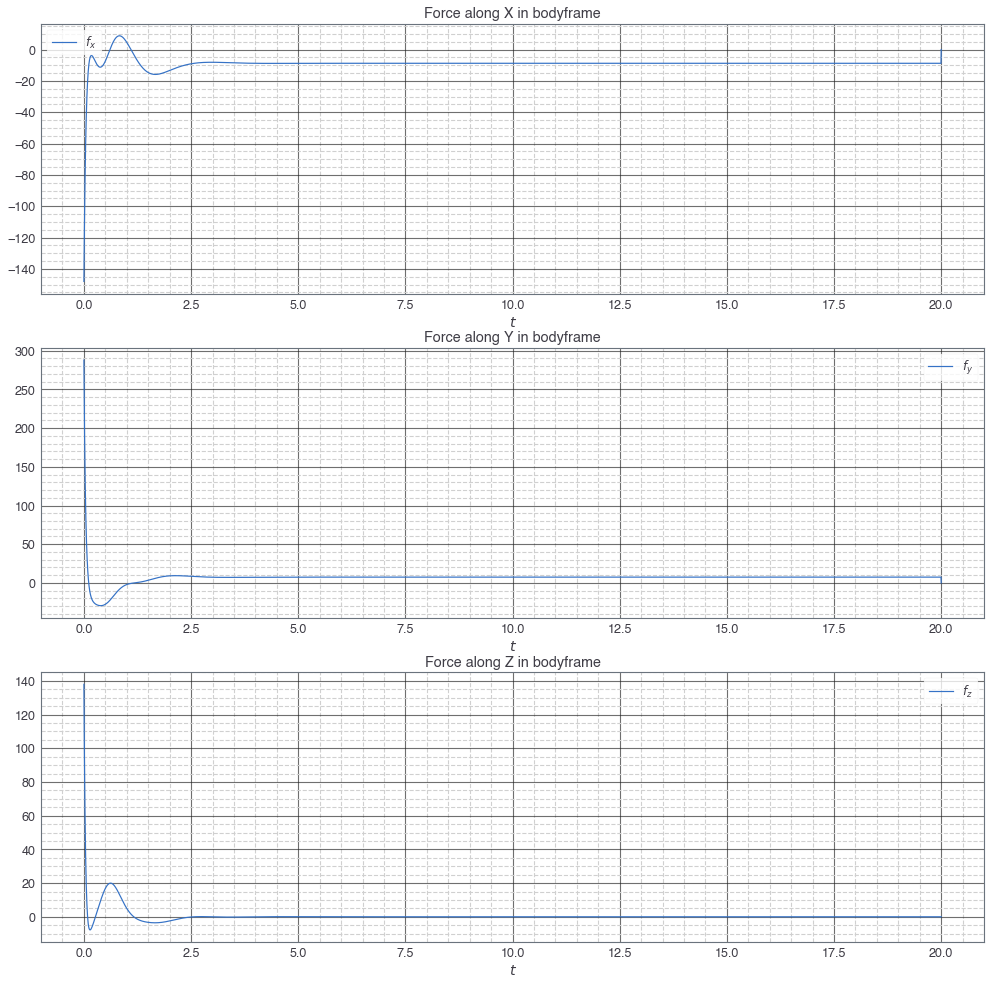

In [16]:
plt.figure(0,figsize = (16.9,16.9))

plt.subplot(3,1,1)
plt.grid()
plt.plot(t_values,U[0,:],label=r'$f_x$')
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.title("Force along X in bodyframe")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()

plt.subplot(3,1,2)
plt.grid()
plt.plot(t_values,U[1,:],label=r'$f_y$')
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.title("Force along Y in bodyframe")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()

plt.subplot(3,1,3)
plt.grid()
plt.plot(t_values,U[2,:],label=r'$f_z$')
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.title("Force along Z in bodyframe")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()

plt.show()

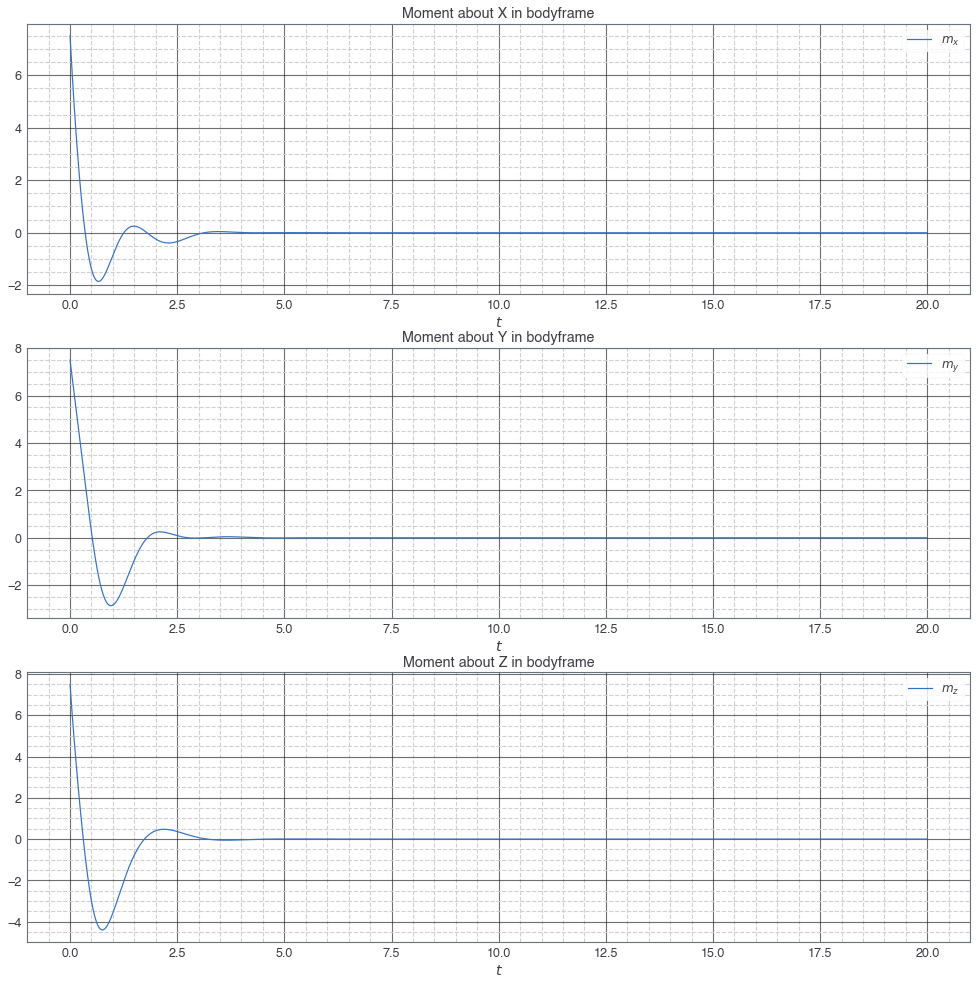

In [17]:
plt.figure(0,figsize = (16.9,16.9))

plt.subplot(3,1,1)
plt.grid()
plt.plot(t_values,U[3,:],label=r'$m_x$')
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.title("Moment about X in bodyframe")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()


plt.subplot(3,1,2)
plt.grid()
plt.plot(t_values,U[4,:],label=r'$m_y$')
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.title("Moment about Y in bodyframe")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()

plt.subplot(3,1,3)
plt.grid()
plt.plot(t_values,U[5,:],label=r'$m_z$')
plt.legend(loc = 0)
plt.xlabel(r'$t$')
plt.title("Moment about Z in bodyframe")
plt.grid(b=True, which='major', color = 'k',linestyle='-',alpha = 0.65)
plt.grid(b=True, which='minor', linestyle='--')
plt.minorticks_on()


plt.show()